##### 算法链和管道
+ 使用pipeline类来简化构建变换和模型的链的过程

In [69]:
#举例：
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

import mglearn

In [23]:
# 加载并划分数据
cancer = load_breast_cancer()
Xtrain,Xtest,ytrain,ytest = train_test_split(cancer['data'],cancer['target'],random_state = 0)

# 计算最大值最小值
scaler = MinMaxScaler().fit(Xtrain)

#对训练数据缩放
Xtrain_scaled = scaler.transform(Xtrain)

svm = SVC() 
# 在缩放后训练数据上学习svm

svm.fit(Xtrain_scaled,ytrain)

# 对测试集缩放
Xtest_scaled =scaler.transform(Xtest)
print("test score :{:.3f}".format(svm.score(Xtest_scaled,ytest)))

test score :0.972


Best cross-valodation accuracy:0.981
Best set score:0.972
Best parameter:  {'C': 1, 'gamma': 1}


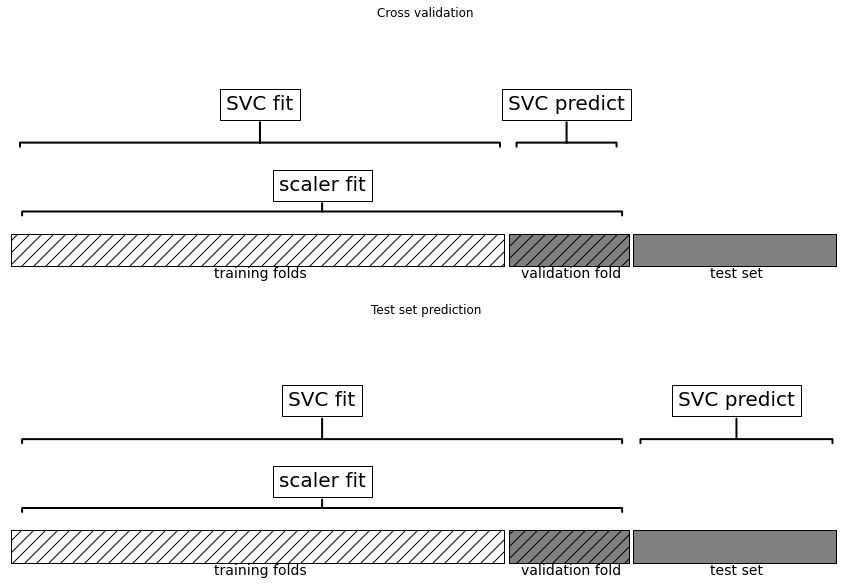

In [12]:
# 用预处理进行参数选择
# 假设我们希望用GridSearchCV来找到更好的svc参数

# 创建参数网格

param_grid = {
    "C":[0.001,0.01,0.01,1,10,100],
    "gamma":[0.001,0.01,0.01,1,10,100]
}
grid = GridSearchCV(svm,param_grid,cv=5)
grid.fit(Xtrain_scaled,ytrain)

print("Best cross-valodation accuracy:{:.3f}".format(grid.best_score_))
print("Best set score:{:.3f}".format(grid.score(Xtest_scaled,ytest)))
print("Best parameter: ",grid.best_params_)


# 上述代码存在陷阱： 当缩放数据时，我们使用了训练集中所有的数据来找到训练方法，然后我们使用缩放后的训练数据来运行带交叉验证的网格搜索；对于交叉验证的每次划分,原始训练集的一部分被划分为训练部分，另一部分被划分为测试部分。测试部分用于度量在训练部分上
# 所训练的模型在新数据上的表现.但是，我们在缩放数据是已经使用过测试部分所包含的信息了，交叉验证每次划分的测试部分都是训练集的一部分，我们使用整个训练集的信息来找到数据的正确缩放
# 对于模型来说，这些数据与新数据看起来截然不同,如果我们观察新数据（比如测试集中的数据），那么这些数据并没有对用于对训练数据进行缩放，其最大值和最小值可能也可能与训练数据不同
# 因此，对于建模过程，交叉验证中的划分无法正确的反应新数据的特征，我们已经将这部分数据的信息泄露给（leak）建模过程，这将导致在交叉验证中得到过于乐观的分数

# 解决方法：在交叉验证过程中，应该在进行任何预处理之前完成数据集的划分，任何从数据集中提取信息的处理过程都应该仅应用于数据集的训练部分，因为，任何交叉验证都应该位于处理过程的“最外成循环”

# 在sklearn中 要想使用cross_val_score函数和GridSearchCV 函数来实现这一点 可以使用pipline类 ，这个类可以将多个处理不愁合并（glue）为单个sklearn估计器
mglearn.plots.plot_improper_processing()

In [31]:
# 管道常见用例： 将预处理步骤和一个监督模型链接在一起 
# 构建管道



pipe = Pipeline([("scaler",MinMaxScaler()),("svm",SVC())])
# 创建两个步骤 一个缩放步骤 一个svc模型

In [22]:
pipe.fit(Xtrain,ytrain)
print("test score:{:.3f}".format(pipe.score(Xtest,ytest)))

test score:0.972


Best cross-valodation accuracy:0.981
Best set score:0.972
Best parameter:  {'svm__C': 1, 'svm__gamma': 1}


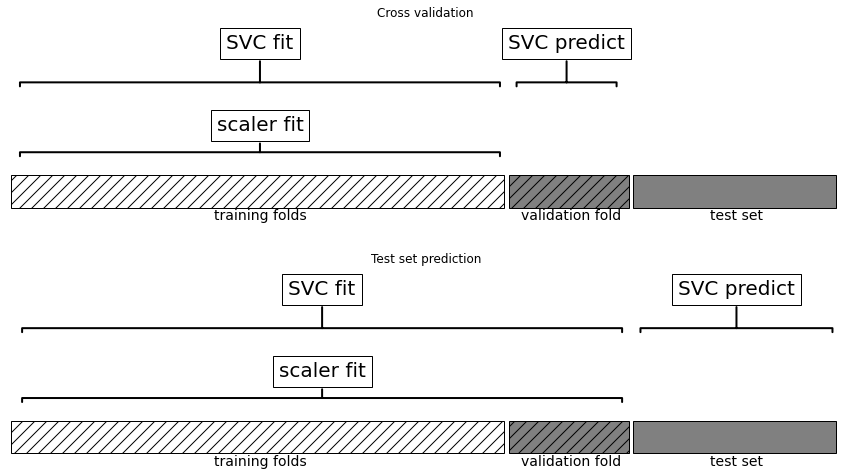

In [30]:
## 在网格搜索中使用管道
param_grid = {
    "svm__C":[0.001,0.01,0.01,1,10,100],
    "svm__gamma":[0.001,0.01,0.01,1,10,100]
}
grid = GridSearchCV(pipe,param_grid=param_grid,cv=5)
grid.fit(Xtrain,ytrain)

print("Best cross-valodation accuracy:{:.3f}".format(grid.best_score_))
print("Best set score:{:.3f}".format(grid.score(Xtest,ytest)))
print("Best parameter: ",grid.best_params_)


# 与前面所做的网格搜索不同，对于现在的交叉验证来说，使用训练部分对MinMaxscaler进行拟合，测试部分的信息没有泄露到参数搜索当中去

mglearn.plots.plot_proper_processing()

In [32]:
# 在交叉验证中，信息泄露的影响大小取决于预处理步骤的性质.使用测试部分来估计数据的范围，通常不产生可怕的影响，但在特征提取和特征选择中使用测试部分，则会导致结果的显著差异
# 通用的管道接口：pipeline类不但可以用于预处理和分类，实际上还可以将任意数量的估计器链接在一起
# 例如：可以构建一个包含特征提取，特征选择，缩放和分类的管道，总共有四个步骤，同样最后一步可以用回归或者聚类代替分类

# 对于管道中的估计器的唯一要求就是，出最后一步之外所有的步骤都需要具有transform方法，这样他们可以生成新的数据表示，共下一步骤使用

In [33]:
# 用make_pipeline 方便的创建管道
make_pipe = make_pipeline(MinMaxScaler(),SVC(C=100))
print("pipe step:\n{}".format(make_pipe.steps))

pipe step:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [36]:
# 
from sklearn.decomposition import PCA 

pipe = make_pipeline(StandardScaler(),PCA(n_components=2),StandardScaler())
pipe.steps

[('standardscaler-1', StandardScaler()),
 ('pca', PCA(n_components=2)),
 ('standardscaler-2', StandardScaler())]

In [38]:
# 访问步骤属性
# 用前面定义的管道对cancer数据集进行拟合
pipe.fit(cancer['data'])
# 从"pca" 步骤中提取前两个主成分
components = pipe.named_steps["pca"].components_

print("components :{}".format(components))

# cong

components :[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


In [50]:
# 访问网格搜索管道中的属性


pipe = make_pipeline(StandardScaler(),LogisticRegression(max_iter=500))

# 创建网格
param_grid = {'logisticregression__C':[0.01,0.1,1,10,100]}

Xtrain,Xtest ,ytrain,ytest = train_test_split(cancer['data'],cancer['target'],random_state=4)
grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(Xtrain,ytrain)

print("best estimator :\n{}".format(grid.best_estimator_))
# 通过pipe的name_steps 属性来访问各个步骤中的估计器


best estimator :
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=500))])


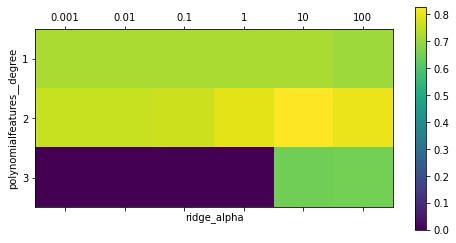

In [62]:
# 网格搜索预处理步骤和模型参数

# 举例： 我们使用监督任务的出来来调节预处理参数
from sklearn.datasets import load_boston 

boston = load_boston()

Xtrain,Xtest,ytrain,ytest = train_test_split(boston.data,boston.target,random_state = 0)
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())
param_grid={
        "polynomialfeatures__degree":[1,2,3],
        "ridge__alpha":[0.001,0.01,0.1,1,10,100]
           }

grid  = GridSearchCV(pipe,param_grid ,cv =5)

grid.fit(Xtrain,ytrain)

#用热图将交叉验证可视化
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3,-1),vmin=0,cmap="viridis")
plt.xlabel('ridge_alpha')
plt.ylabel('polynomialfeatures__degree')
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [67]:
print("best parameters :\n{}".format(grid.best_params_))
print("best scores:{:.3f}".format(grid.score(Xtest,ytest)))

best parameters :
{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
best scores:0.768


In [76]:
# 网格搜索选择使用哪个模型
# 你甚至可以进一步将GridSearchcv 和 pipeline结合起来， 还可以在搜索管道中正在执行的实际步骤


# 对比两个分类器 
# 显示定义管道
pipe = Pipeline([('preprocessing',StandardScaler()),('classifier',SVC())])


param_grid = [
    {
        "classifier":[SVC()],"preprocessing":[StandardScaler(),None],
        "classifier__gamma":[0.001,0.01,0.1,1,10,100],
        "classifier__C":[0.001,0.01,0.1,1,10,100]
    },
    {
        "classifier":[RandomForestClassifier(n_estimators=100)],
        "preprocessing":[None],
        "classifier__max_features":[1,2,3]
    }
]


Xtrain,Xtest,ytrain,ytest = train_test_split(cancer.data,cancer.target,random_state=0)

grid = GridSearchCV(pipe,param_grid ,cv=5)
grid.fit(Xtrain,ytrain)


print("best parameters :\n{}".format(grid.best_params_))
print("best scores:{:.3f}".format(grid.best_score_))
print("test set scores:{:.3f}".format(grid.score(Xtest,ytest)))

best parameters :
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}
best scores:0.986
test set scores:0.979
